In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'relative'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_relative_about'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5863571854418579 	 Validation loss: 0.43102459331690257 	 
  1%|          | 574/57400 [02:10<3:27:48,  4.56it/s]
Epoch 2 	 Training loss: 0.3967473776913686 	 Validation loss: 0.3617963997994439 	 
  2%|▏         | 1148/57400 [04:23<3:27:17,  4.52it/s]
Epoch 3 	 Training loss: 0.355739187228555 	 Validation loss: 0.34404088733559945 	 
  3%|▎         | 1722/57400 [06:32<3:23:52,  4.55it/s]
Epoch 4 	 Training loss: 0.3359579906802144 	 Validation loss: 0.33427065812935264 	 
  4%|▍         | 2296/57400 [08:42<3:24:55,  4.48it/s]
Epoch 5 	 Training loss: 0.32243224960274813 	 Validation loss: 0.32795872248835484 	 
  5%|▌         | 2870/57400 [10:51<3:15:32,  4.65it/s]
Epoch 6 	 Training loss: 0.31116889871475173 	 Validation loss: 0.3228487099631358 	 
  6%|▌         | 3444/57400 [13:01<3:12:43,  4.67it/s]
Epoch 7 	 Training loss: 0.30267766909836064 	 Validation loss: 0.3160159176183959 	 
  7%|▋         | 4018/57400 [15:12<3:12:20,  4.63it/s]
Epoch 8 	 Train

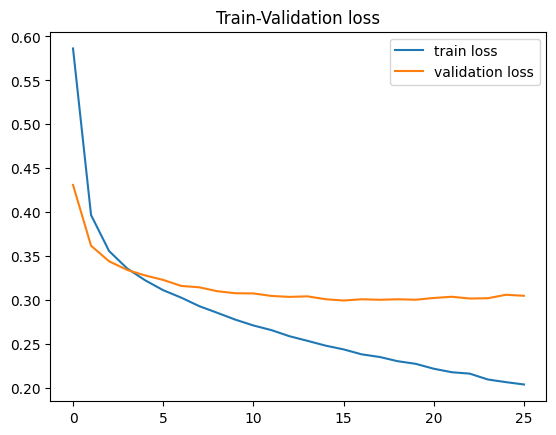

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8392857142857143, 'precision': 0.8392857142857143, 'f1': 0.8392857142857143, 'accuracy': 0.8392857142857143}
MALE {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}
FEMALE {'recall': 0.83, 'precision': 0.83, 'f1': 0.83, 'accuracy': 0.83} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6603535353535354, 'precision': 0.6603535353535354, 'f1': 0.6603535353535354, 'accuracy': 0.6603535353535354}
MALE {'recall': 0.6909975669099757, 'precision': 0.6909975669099757, 'f1': 0.6909975669099757, 'accuracy': 0.6909975669099757}
FEMALE {'recall': 0.6272965879265092, 'precision': 0.6272965879265092, 'f1': 0.6272965879265092, 'accuracy': 0.6272965879265092} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6844850065189049, 'precision': 0.6844850065189049, 'f1': 0.6844850065189049, 'accuracy': 0.6844850065189049}
MALE {'recall': 0.684343

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5605949752214479 	 Validation loss: 0.4076961773937031 	 
  1%|          | 574/57400 [02:03<2:41:06,  5.88it/s]
Epoch 2 	 Training loss: 0.384972086273627 	 Validation loss: 0.3542996506064625 	 
  2%|▏         | 1148/57400 [04:07<3:14:04,  4.83it/s]
Epoch 3 	 Training loss: 0.3505586514489576 	 Validation loss: 0.3384027488655963 	 
  3%|▎         | 1722/57400 [06:10<2:41:00,  5.76it/s]
Epoch 4 	 Training loss: 0.331945224376298 	 Validation loss: 0.3303983974254737 	 
  4%|▍         | 2296/57400 [08:14<3:04:54,  4.97it/s]
Epoch 5 	 Training loss: 0.3197813679168864 	 Validation loss: 0.3232173068543612 	 
  5%|▌         | 2870/57400 [10:17<3:09:56,  4.78it/s]
Epoch 6 	 Training loss: 0.30762046362672535 	 Validation loss: 0.3155691353446346 	 
  6%|▌         | 3444/57400 [12:20<2:32:25,  5.90it/s]
Epoch 7 	 Training loss: 0.29835121141493526 	 Validation loss: 0.31246282488612803 	 
  7%|▋         | 4018/57400 [14:24<3:02:35,  4.87it/s]
Epoch 8 	 Training l

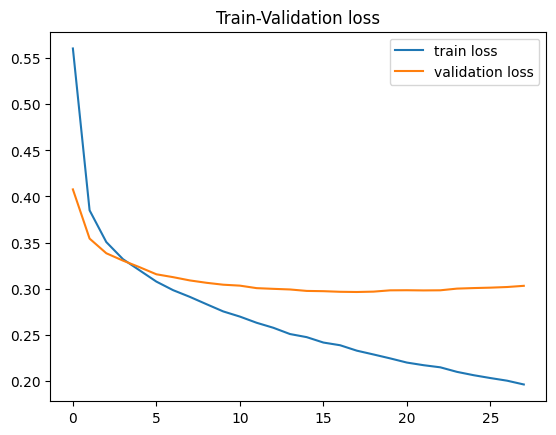

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_relative_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8456632653061225, 'precision': 0.8456632653061225, 'f1': 0.8456632653061225, 'accuracy': 0.8456632653061225}
MALE {'recall': 0.8619791666666666, 'precision': 0.8619791666666666, 'f1': 0.8619791666666666, 'accuracy': 0.8619791666666666}
FEMALE {'recall': 0.83, 'precision': 0.83, 'f1': 0.83, 'accuracy': 0.83} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6654040404040404, 'precision': 0.6654040404040404, 'f1': 0.6654040404040404, 'accuracy': 0.6654040404040404}
MALE {'recall': 0.6885644768856448, 'precision': 0.6885644768856448, 'f1': 0.6885644768856448, 'accuracy': 0.6885644768856448}
FEMALE {'recall': 0.6404199475065617, 'precision': 0.6404199475065617, 'f1': 0.6404199475065617, 'accuracy': 0.6404199475065617} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6805736636245111, 'precision': 0.6805736636245111, 'f1': 0.6805736636245111, 'accuracy': 0.6805736636245111}
MALE {'recall': 0.671717

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5703245880607944 	 Validation loss: 0.42293012647305506 	 
  1%|          | 574/57400 [02:03<3:15:28,  4.85it/s]
Epoch 2 	 Training loss: 0.3919544920896404 	 Validation loss: 0.35989813531859444 	 
  2%|▏         | 1148/57400 [04:06<2:39:31,  5.88it/s]
Epoch 3 	 Training loss: 0.3527572588015101 	 Validation loss: 0.340146718894021 	 
  3%|▎         | 1722/57400 [06:10<2:40:45,  5.77it/s]
Epoch 4 	 Training loss: 0.3332392569202995 	 Validation loss: 0.3317302576566147 	 
  4%|▍         | 2296/57400 [08:20<3:19:13,  4.61it/s]
Epoch 5 	 Training loss: 0.3189112506157845 	 Validation loss: 0.32356670044236263 	 
  5%|▌         | 2870/57400 [10:32<3:19:07,  4.56it/s]
Epoch 6 	 Training loss: 0.3090994322237653 	 Validation loss: 0.32001478717488757 	 
  6%|▌         | 3444/57400 [12:44<3:13:14,  4.65it/s]
Epoch 7 	 Training loss: 0.299161586637904 	 Validation loss: 0.3126489277613365 	 
  7%|▋         | 4018/57400 [14:55<2:47:23,  5.31it/s]
Epoch 8 	 Training 

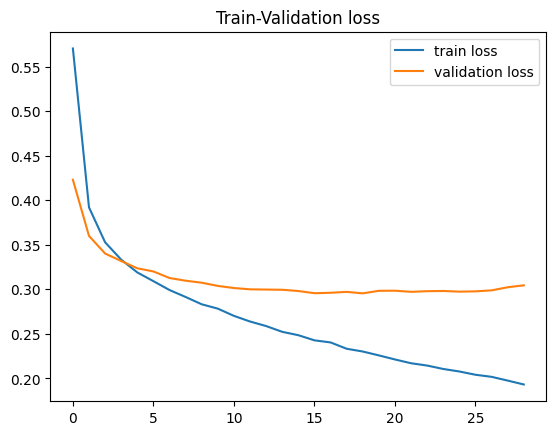

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_relative_about3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8443877551020408, 'precision': 0.8443877551020408, 'f1': 0.8443877551020407, 'accuracy': 0.8443877551020408}
MALE {'recall': 0.8567708333333334, 'precision': 0.8567708333333334, 'f1': 0.8567708333333334, 'accuracy': 0.8567708333333334}
FEMALE {'recall': 0.8325, 'precision': 0.8325, 'f1': 0.8325, 'accuracy': 0.8325} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6641414141414141, 'precision': 0.6641414141414141, 'f1': 0.6641414141414141, 'accuracy': 0.6641414141414141}
MALE {'recall': 0.6909975669099757, 'precision': 0.6909975669099757, 'f1': 0.6909975669099757, 'accuracy': 0.6909975669099757}
FEMALE {'recall': 0.6351706036745407, 'precision': 0.6351706036745407, 'f1': 0.6351706036745407, 'accuracy': 0.6351706036745407} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6792698826597132, 'precision': 0.6792698826597132, 'f1': 0.6792698826597132, 'accuracy': 0.6792698826597132}
MALE {'recall': 

Resultados finales

In [23]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8431122448979592, 'precision': 0.8431122448979592, 'f1': 0.8431122448979591, 'accuracy': 0.8431122448979592}
Métricas etiqueta male: {'recall': 0.8559027777777778, 'precision': 0.8559027777777778, 'f1': 0.8559027777777778, 'accuracy': 0.8559027777777778}
Métricas etiqueta female:  {'recall': 0.8308333333333333, 'precision': 0.8308333333333333, 'f1': 0.8308333333333333, 'accuracy': 0.8308333333333333}

 to
Resultado global: {'recall': 0.6632996632996633, 'precision': 0.6632996632996633, 'f1': 0.6632996632996633, 'accuracy': 0.6632996632996633}
Métricas etiqueta male: {'recall': 0.6901865369018654, 'precision': 0.6901865369018654, 'f1': 0.6901865369018654, 'accuracy': 0.6901865369018654}
Métricas etiqueta female:  {'recall': 0.6342957130358705, 'precision': 0.6342957130358705, 'f1': 0.6342957130358705, 'accuracy': 0.6342957130358705}

 as
Resultado global: {'recall': 0.6814428509343764, 'precision': 0.6814428509343764, 'f1': 0.6

# TO

In [23]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.694853865830325 	 Validation loss: 0.6935148865489636 	 
  1%|          | 574/57400 [02:05<3:18:33,  4.77it/s]
Epoch 2 	 Training loss: 0.6943151966412309 	 Validation loss: 0.6938282311972925 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:09<3:22:14,  4.64it/s]
Epoch 3 	 Training loss: 0.6944599286604426 	 Validation loss: 0.6929982557135114 	 
  3%|▎         | 1722/57400 [06:15<3:05:39,  5.00it/s]
Epoch 4 	 Training loss: 0.6941559434144754 	 Validation loss: 0.6927574044567043 	 
  4%|▍         | 2296/57400 [08:20<4:18:23,  3.55it/s]
Epoch 5 	 Training loss: 0.6941221551612694 	 Validation loss: 0.6935654292672367 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [10:25<3:21:10,  4.52it/s]
Epoch 6 	 Training loss: 0.6938735990158772 	 Validation loss: 0.6937673839472108 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [12:30<2:37:17,  5.72it/s]
Epoch 7 	 Training loss: 0.6937295412352692 	 Validation loss: 0.6937155289

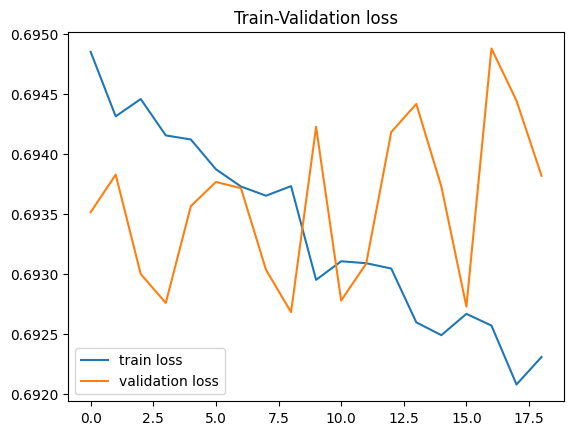

In [25]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_relative_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [24]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('distilbert_relative_to'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.46938775510204084, 'precision': 0.46938775510204084, 'f1': 0.46938775510204084, 'accuracy': 0.46938775510204084}
MALE {'recall': 0.4635416666666667, 'precision': 0.4635416666666667, 'f1': 0.4635416666666667, 'accuracy': 0.4635416666666667}
FEMALE {'recall': 0.475, 'precision': 0.475, 'f1': 0.47500000000000003, 'accuracy': 0.475} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5151515151515151, 'precision': 0.5151515151515151, 'f1': 0.5151515151515151, 'accuracy': 0.5151515151515151}
MALE {'recall': 0.46958637469586373, 'precision': 0.46958637469586373, 'f1': 0.46958637469586373, 'accuracy': 0.46958637469586373}
FEMALE {'recall': 0.5643044619422573, 'precision': 0.5643044619422573, 'f1': 0.5643044619422573, 'accuracy': 0.5643044619422573} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5032594524119948, 'precision': 0.5032594524119948, 'f1': 0.5032594524119948, 'accuracy': 0.5032594524119948

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6958122580516629 	 Validation loss: 0.6928552682116881 	 
  1%|          | 574/57400 [02:09<3:23:34,  4.65it/s]
Epoch 2 	 Training loss: 0.694939759757876 	 Validation loss: 0.6938269704075183 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:18<3:25:27,  4.56it/s]
Epoch 3 	 Training loss: 0.6945107081833617 	 Validation loss: 0.69329545659534 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [06:28<2:50:30,  5.44it/s]
Epoch 4 	 Training loss: 0.6945016099600841 	 Validation loss: 0.6931513052875713 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [08:38<3:51:39,  3.96it/s]
Epoch 5 	 Training loss: 0.6939884383711665 	 Validation loss: 0.6928950437044693 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [10:51<3:20:38,  4.53it/s]
Epoch 6 	 Training loss: 0.6938500766762458 	 Validation loss: 0.6923415064811707 	 
  6%|▌         | 3444/57400 [13:01<3:11:45,  4.69it/s]
Epoch 7 	 Training loss: 0.6941397069638614 	 Va

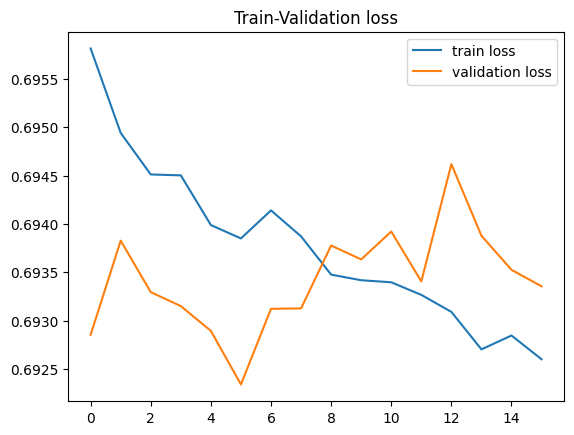

In [27]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_relative_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('distilbert_relative_to2'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5038265306122449, 'precision': 0.5038265306122449, 'f1': 0.5038265306122449, 'accuracy': 0.5038265306122449}
MALE {'recall': 0.2109375, 'precision': 0.2109375, 'f1': 0.2109375, 'accuracy': 0.2109375}
FEMALE {'recall': 0.785, 'precision': 0.785, 'f1': 0.785, 'accuracy': 0.785} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5202020202020202, 'precision': 0.5202020202020202, 'f1': 0.5202020202020202, 'accuracy': 0.5202020202020202}
MALE {'recall': 0.26763990267639903, 'precision': 0.26763990267639903, 'f1': 0.26763990267639903, 'accuracy': 0.26763990267639903}
FEMALE {'recall': 0.7926509186351706, 'precision': 0.7926509186351706, 'f1': 0.7926509186351706, 'accuracy': 0.7926509186351706} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4941329856584094, 'precision': 0.4941329856584094, 'f1': 0.4941329856584094, 'accuracy': 0.4941329856584094}
MALE {'recall': 0.26262626262626265, 'precision': 0.

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6945577567047359 	 Validation loss: 0.694261017492262 	 
  1%|          | 574/57400 [02:05<3:25:40,  4.60it/s]
Epoch 2 	 Training loss: 0.6936782675337708 	 Validation loss: 0.6937769994897357 	 
  2%|▏         | 1148/57400 [04:10<3:20:37,  4.67it/s]
Epoch 3 	 Training loss: 0.6936015858467448 	 Validation loss: 0.6936500618013285 	 
  3%|▎         | 1722/57400 [06:16<2:41:04,  5.76it/s]
Epoch 4 	 Training loss: 0.6933728028672913 	 Validation loss: 0.6935467548289541 	 
  4%|▍         | 2296/57400 [08:21<3:15:07,  4.71it/s]
Epoch 5 	 Training loss: 0.6930710683716299 	 Validation loss: 0.6949458021228596 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [10:26<3:14:44,  4.67it/s]
Epoch 6 	 Training loss: 0.6932814502342237 	 Validation loss: 0.6929547251281092 	 
  6%|▌         | 3444/57400 [12:32<3:03:44,  4.89it/s]
Epoch 7 	 Training loss: 0.6926716010537297 	 Validation loss: 0.6941115017664634 	 

1 epoch without improvement
  7%|▋         | 40

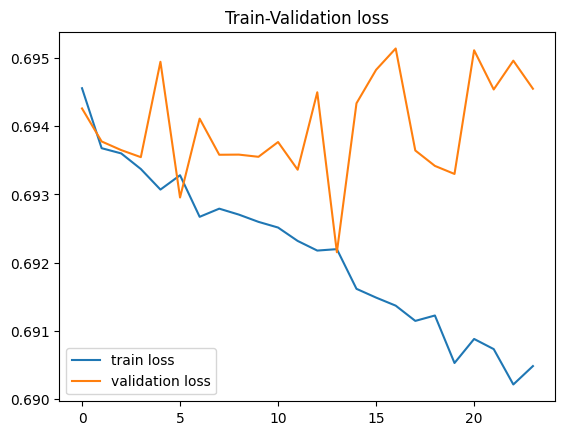

In [29]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_relative_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [26]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('distilbert_relative_to3'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5612244897959183, 'precision': 0.5612244897959183, 'f1': 0.5612244897959183, 'accuracy': 0.5612244897959183}
MALE {'recall': 0.3307291666666667, 'precision': 0.3307291666666667, 'f1': 0.3307291666666667, 'accuracy': 0.3307291666666667}
FEMALE {'recall': 0.7825, 'precision': 0.7825, 'f1': 0.7825, 'accuracy': 0.7825} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5681818181818182, 'precision': 0.5681818181818182, 'f1': 0.5681818181818182, 'accuracy': 0.5681818181818182}
MALE {'recall': 0.3284671532846715, 'precision': 0.3284671532846715, 'f1': 0.3284671532846715, 'accuracy': 0.3284671532846715}
FEMALE {'recall': 0.8267716535433071, 'precision': 0.8267716535433071, 'f1': 0.8267716535433071, 'accuracy': 0.8267716535433071} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.560625814863103, 'precision': 0.560625814863103, 'f1': 0.560625814863103, 'accuracy': 0.560625814863103}
MALE {'recall': 0.33

Resultados finales

In [27]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5114795918367347, 'precision': 0.5114795918367347, 'f1': 0.5114795918367347, 'accuracy': 0.5114795918367347}
Métricas etiqueta male: {'recall': 0.3350694444444445, 'precision': 0.3350694444444445, 'f1': 0.3350694444444445, 'accuracy': 0.3350694444444445}
Métricas etiqueta female:  {'recall': 0.6808333333333333, 'precision': 0.6808333333333333, 'f1': 0.6808333333333334, 'accuracy': 0.6808333333333333}

 to
Resultado global: {'recall': 0.5345117845117845, 'precision': 0.5345117845117845, 'f1': 0.5345117845117845, 'accuracy': 0.5345117845117845}
Métricas etiqueta male: {'recall': 0.35523114355231145, 'precision': 0.35523114355231145, 'f1': 0.35523114355231145, 'accuracy': 0.35523114355231145}
Métricas etiqueta female:  {'recall': 0.7279090113735783, 'precision': 0.7279090113735783, 'f1': 0.7279090113735783, 'accuracy': 0.7279090113735783}

 as
Resultado global: {'recall': 0.5193394176445024, 'precision': 0.5193394176445024, 'f1':

# AS

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6941194893591079 	 Validation loss: 0.6922779891450527 	 
  1%|          | 574/57400 [02:41<3:47:49,  4.16it/s]
Epoch 2 	 Training loss: 0.6926903764129931 	 Validation loss: 0.6924775677212214 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [05:00<3:30:15,  4.46it/s]
Epoch 3 	 Training loss: 0.6910315636766081 	 Validation loss: 0.6919202935897698 	 
  3%|▎         | 1722/57400 [07:36<4:52:35,  3.17it/s]
Epoch 4 	 Training loss: 0.6897238102524123 	 Validation loss: 0.6924399208214324 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [10:48<3:38:28,  4.20it/s]
Epoch 5 	 Training loss: 0.6884266545132893 	 Validation loss: 0.6919736730850349 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [13:14<3:41:38,  4.10it/s]
Epoch 6 	 Training loss: 0.6864523399582307 	 Validation loss: 0.6929425799240501 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [15:37<3:41:08,  4.07it/s]
Epoch 7 	 Training loss: 0.686074664160765 	 

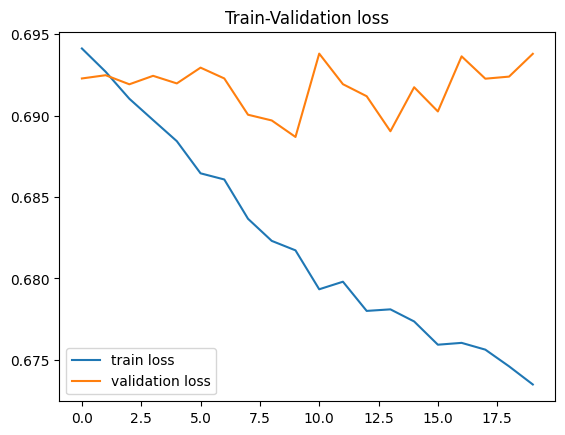

In [30]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_relative_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('distilbert_relative_as'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6607142857142857, 'precision': 0.6607142857142857, 'f1': 0.6607142857142857, 'accuracy': 0.6607142857142857}
MALE {'recall': 0.6614583333333334, 'precision': 0.6614583333333334, 'f1': 0.6614583333333334, 'accuracy': 0.6614583333333334}
FEMALE {'recall': 0.66, 'precision': 0.66, 'f1': 0.66, 'accuracy': 0.66} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6717171717171717, 'precision': 0.6717171717171717, 'f1': 0.6717171717171717, 'accuracy': 0.6717171717171717}
MALE {'recall': 0.6982968369829684, 'precision': 0.6982968369829684, 'f1': 0.6982968369829684, 'accuracy': 0.6982968369829684}
FEMALE {'recall': 0.6430446194225722, 'precision': 0.6430446194225722, 'f1': 0.6430446194225722, 'accuracy': 0.6430446194225722} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7131681877444589, 'precision': 0.7131681877444589, 'f1': 0.713168187744459, 'accuracy': 0.7131681877444589}
MALE {'recall': 0.6565656

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.695529681672618 	 Validation loss: 0.6938233042167405 	 
  1%|          | 574/57400 [02:16<3:57:54,  3.98it/s]
Epoch 2 	 Training loss: 0.69351594103338 	 Validation loss: 0.6925070285797119 	 
  2%|▏         | 1148/57400 [04:36<3:44:21,  4.18it/s]
Epoch 3 	 Training loss: 0.6923147457609609 	 Validation loss: 0.692497735306368 	 
  3%|▎         | 1722/57400 [06:55<3:36:14,  4.29it/s]
Epoch 4 	 Training loss: 0.6908208618803722 	 Validation loss: 0.6905558422460394 	 
  4%|▍         | 2296/57400 [09:26<3:43:00,  4.12it/s]
Epoch 5 	 Training loss: 0.6895178178461586 	 Validation loss: 0.6935948133468628 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [11:48<2:59:19,  5.07it/s]
Epoch 6 	 Training loss: 0.6887284797658488 	 Validation loss: 0.6940659183566853 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [14:09<3:00:35,  4.98it/s]
Epoch 7 	 Training loss: 0.6875194699506726 	 Validation loss: 0.692943788180917 	 

3 epoch without improv

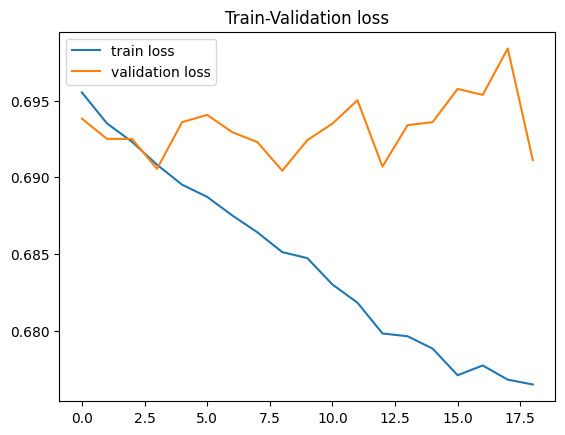

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_relative_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6147959183673469, 'precision': 0.6147959183673469, 'f1': 0.6147959183673469, 'accuracy': 0.6147959183673469}
MALE {'recall': 0.578125, 'precision': 0.578125, 'f1': 0.578125, 'accuracy': 0.578125}
FEMALE {'recall': 0.65, 'precision': 0.65, 'f1': 0.65, 'accuracy': 0.65} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6212121212121212, 'precision': 0.6212121212121212, 'f1': 0.6212121212121212, 'accuracy': 0.6212121212121212}
MALE {'recall': 0.5936739659367397, 'precision': 0.5936739659367397, 'f1': 0.5936739659367397, 'accuracy': 0.5936739659367397}
FEMALE {'recall': 0.6509186351706037, 'precision': 0.6509186351706037, 'f1': 0.6509186351706037, 'accuracy': 0.6509186351706037} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6427640156453716, 'precision': 0.6427640156453716, 'f1': 0.6427640156453716, 'accuracy': 0.6427640156453716}
MALE {'recall': 0.5656565656565656, 'precision': 0.5656565656565

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6948137119256661 	 Validation loss: 0.6919812661106304 	 
  1%|          | 574/57400 [02:33<2:51:34,  5.52it/s]
Epoch 2 	 Training loss: 0.6932262349419478 	 Validation loss: 0.6934048563747083 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:54<4:30:29,  3.47it/s]
Epoch 3 	 Training loss: 0.6923692060264561 	 Validation loss: 0.6917147767745843 	 
  3%|▎         | 1722/57400 [07:46<4:09:31,  3.72it/s]
Epoch 4 	 Training loss: 0.6907268757396459 	 Validation loss: 0.691603240320238 	 
  4%|▍         | 2296/57400 [10:22<5:05:16,  3.01it/s]
Epoch 5 	 Training loss: 0.6892934022049455 	 Validation loss: 0.692654354087377 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [13:29<4:11:10,  3.62it/s]
Epoch 6 	 Training loss: 0.688275294644492 	 Validation loss: 0.6913870411404108 	 
  6%|▌         | 3444/57400 [16:32<5:38:21,  2.66it/s]
Epoch 7 	 Training loss: 0.6875981889950689 	 Validation loss: 0.6902896933636423 	 
  7%|▋         | 4018

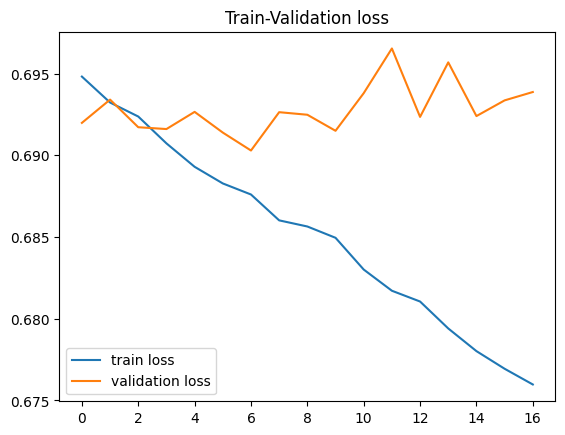

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_relative_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [23]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6071428571428571, 'precision': 0.6071428571428571, 'f1': 0.6071428571428571, 'accuracy': 0.6071428571428571}
MALE {'recall': 0.6484375, 'precision': 0.6484375, 'f1': 0.6484375, 'accuracy': 0.6484375}
FEMALE {'recall': 0.5675, 'precision': 0.5675, 'f1': 0.5675, 'accuracy': 0.5675} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6047979797979798, 'precision': 0.6047979797979798, 'f1': 0.6047979797979798, 'accuracy': 0.6047979797979798}
MALE {'recall': 0.6545012165450121, 'precision': 0.6545012165450121, 'f1': 0.6545012165450121, 'accuracy': 0.6545012165450121}
FEMALE {'recall': 0.5511811023622047, 'precision': 0.5511811023622047, 'f1': 0.5511811023622047, 'accuracy': 0.5511811023622047} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6297262059973925, 'precision': 0.6297262059973925, 'f1': 0.6297262059973925, 'accuracy': 0.6297262059973925}
MALE {'recall': 0.6060606060606061, 'precision': 0.6

Resultados finales

In [24]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6275510204081632, 'precision': 0.6275510204081632, 'f1': 0.6275510204081632, 'accuracy': 0.6275510204081632}
Métricas etiqueta male: {'recall': 0.6293402777777778, 'precision': 0.6293402777777778, 'f1': 0.6293402777777778, 'accuracy': 0.6293402777777778}
Métricas etiqueta female:  {'recall': 0.6258333333333334, 'precision': 0.6258333333333334, 'f1': 0.6258333333333334, 'accuracy': 0.6258333333333334}

 to
Resultado global: {'recall': 0.6325757575757576, 'precision': 0.6325757575757576, 'f1': 0.6325757575757576, 'accuracy': 0.6325757575757576}
Métricas etiqueta male: {'recall': 0.6488240064882401, 'precision': 0.6488240064882401, 'f1': 0.6488240064882401, 'accuracy': 0.6488240064882401}
Métricas etiqueta female:  {'recall': 0.6150481189851269, 'precision': 0.6150481189851269, 'f1': 0.6150481189851269, 'accuracy': 0.6150481189851269}

 as
Resultado global: {'recall': 0.6618861364624077, 'precision': 0.6618861364624077, 'f1': 0.6